In [23]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [24]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import peakutils
import locate
import farwave
import time

from scipy import signal

In [25]:
%matplotlib notebook

In [26]:
%sql sqlite:///schema/rch_data_sat.db

u'Connected: None@schema/rch_data_sat.db'

In [27]:
result = %sql select * from experiment

print result

Done.
+----+------------+-----+-----+---------+
| id |  datetime  |  x  |  y  | comment |
+----+------------+-----+-----+---------+
| 1  | 1488673507 | 0.0 | 0.0 |   -150  |
| 2  | 1488673611 | 0.0 | 0.0 |   -150  |
| 3  | 1488673685 | 0.0 | 0.0 |   -150  |
| 4  | 1488673710 | 0.0 | 0.0 |   -150  |
| 5  | 1488673720 | 0.0 | 0.0 |   -150  |
| 6  | 1488673727 | 0.0 | 0.0 |   -150  |
| 7  | 1488673769 | 0.0 | 0.0 |   140   |
| 8  | 1488673776 | 0.0 | 0.0 |   140   |
| 9  | 1488673816 | 0.0 | 0.0 |   140   |
| 10 | 1488673823 | 0.0 | 0.0 |   140   |
| 11 | 1488673829 | 0.0 | 0.0 |   140   |
| 12 | 1488673885 | 0.0 | 0.0 |   130   |
| 13 | 1488673891 | 0.0 | 0.0 |   130   |
| 14 | 1488673898 | 0.0 | 0.0 |   130   |
| 15 | 1488673930 | 0.0 | 0.0 |   120   |
| 16 | 1488673937 | 0.0 | 0.0 |   120   |
| 17 | 1488673943 | 0.0 | 0.0 |   120   |
| 18 | 1488673996 | 0.0 | 0.0 |    90   |
| 19 | 1488674003 | 0.0 | 0.0 |    90   |
| 20 | 1488674009 | 0.0 | 0.0 |    90   |
| 21 | 1488674062 | 0.0 | 0.

In [28]:
result = %sql select * from array

print result

Done.
+---------------+----------+-----+-----+-----------------+---------------+
| experiment_id | array_id |  x  |  y  |        r        |     theta     |
+---------------+----------+-----+-----+-----------------+---------------+
|       3       |    0     | 0.0 | 0.0 |  -6967.84176407 | 13.0620196375 |
|       4       |    0     | 0.0 | 0.0 |  0.285682624552 | 5.23598749039 |
|       5       |    0     | 0.0 | 0.0 |  -317.004875797 | 13.0567110304 |
|       6       |    0     | 0.0 | 0.0 |  -8475.2588631  | 13.0345824557 |
|       7       |    0     | 0.0 | 0.0 |  0.708240116157 | 5.23598748207 |
|       9       |    0     | 0.0 | 0.0 |  0.898190743415 | 5.23598747864 |
|       10      |    0     | 0.0 | 0.0 | -0.585837128074 | 8.37758013839 |
|       11      |    0     | 0.0 | 0.0 |  0.989575402289 |  5.2359874773 |
|       12      |    0     | 0.0 | 0.0 |  11257783.4175  | 5.23323852591 |
|       13      |    0     | 0.0 | 0.0 |  3.61810719652  | 5.23598746546 |
|       14      |  

In [29]:
cur_experiment_id = 7
result = %sql select data from mic where experiment_id = :cur_experiment_id

mic_0 = np.array(result[0][0])
mic_1 = np.array(result[1][0])
mic_2 = np.array(result[2][0])

Done.


<IPython.core.display.Javascript object>


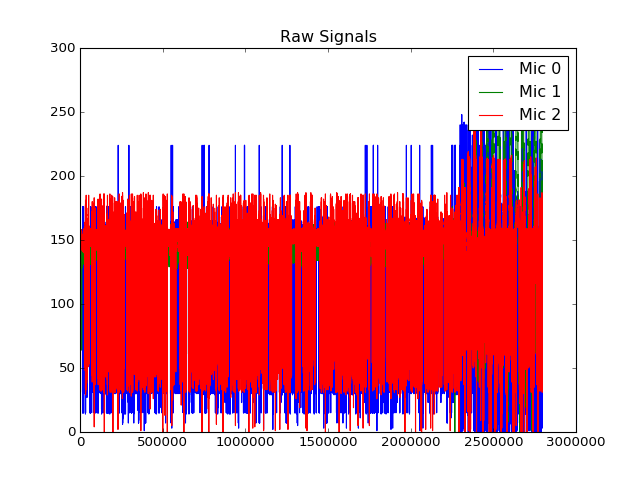

In [30]:
plt.figure()
plt.plot(mic_0, label='Mic 0')
plt.plot(mic_1, label='Mic 1')
plt.plot(mic_2, label='Mic 2')
plt.title('Raw Signals')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


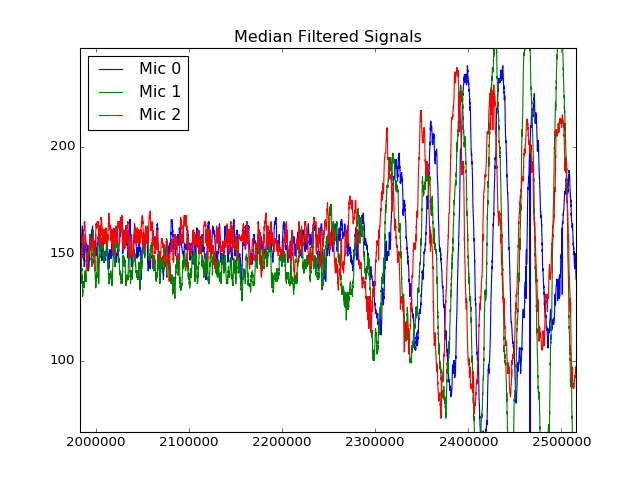

In [31]:
# Plot median filtered signal
mic_0_med = locate.median_filter(mic_0, window=21)
mic_1_med = locate.median_filter(mic_1, window=21)
mic_2_med = locate.median_filter(mic_2, window=21)

plt.figure()
plt.plot(mic_0_med, label='Mic 0')
plt.plot(mic_1_med, label='Mic 1')
plt.plot(mic_2_med, label='Mic 2')
plt.title('Median Filtered Signals')
plt.legend(loc='best')
plt.show()

In [32]:
# Crop the signals
sigs = [mic_0, mic_1, mic_2]
sigs_cropped, sigs_butter_cropped, offsets, sigs_win, peak_idx = locate.crop_sigs_npeaks(sigs)

print offsets

[1704030 1704030 1704030]


<IPython.core.display.Javascript object>


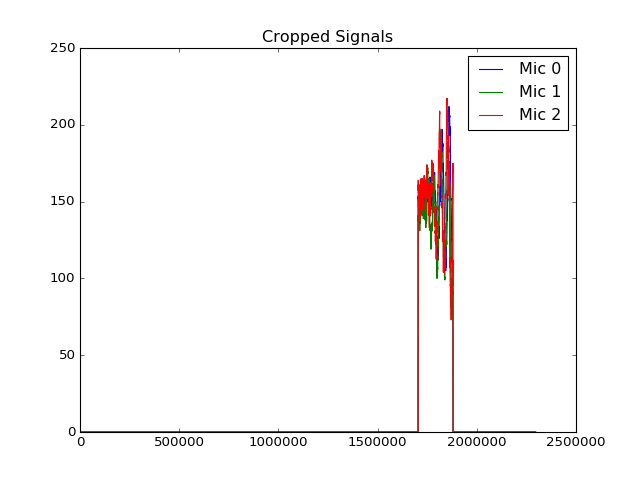

<IPython.core.display.Javascript object>


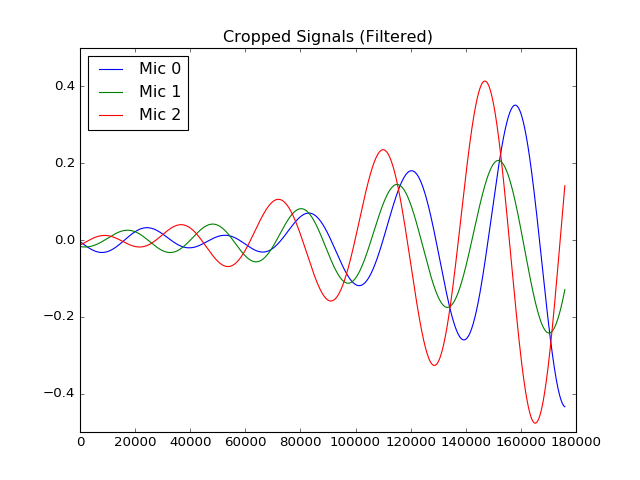

<IPython.core.display.Javascript object>


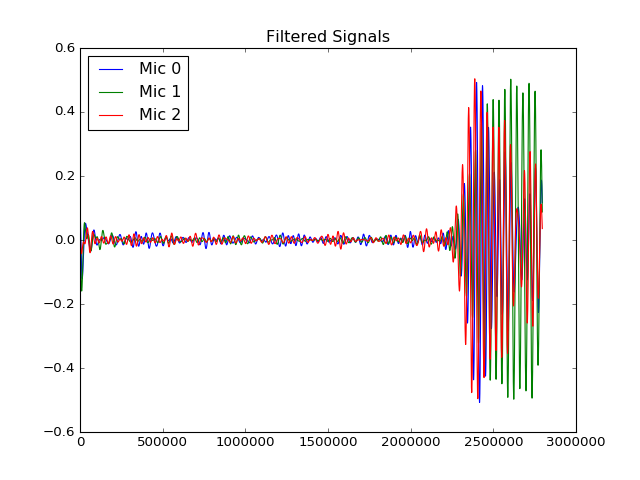

In [33]:
 # Display median filtered signals since xcorr_peaks median filters input
sigs_win = [locate.median_filter(sig) for sig in sigs_win]    

plt.figure()
plt.plot(sigs_win[0], label='Mic 0')
plt.plot(sigs_win[1], label='Mic 1')
plt.plot(sigs_win[2], label='Mic 2')
plt.title('Cropped Signals')
plt.legend(loc='best')
plt.show()

plt.figure()
plt.plot(sigs_butter_cropped[0], label='Mic 0')
plt.plot(sigs_butter_cropped[1], label='Mic 1')
plt.plot(sigs_butter_cropped[2], label='Mic 2')
plt.title('Cropped Signals (Filtered)')
plt.legend(loc='best')
plt.show()

plt.figure()
sig_butters = [locate.normalize_signal(
    locate.apply_ideal_bp(
        locate.FREQ_1, locate.FREQ_2, locate.SAMPLING_FREQ, sig
    )
) for sig in sigs]
plt.plot(sig_butters[0], label='Mic 0')
plt.plot(sig_butters[1], label='Mic 1')
plt.plot(sig_butters[2], label='Mic 2')
plt.title('Filtered Signals')
plt.legend(loc='best')
plt.show()

In [34]:
l = 0.3 # Length from mic to centre of array
MIC_IND_LR = {
    0: (1, 2),
    1: (2, 0),
    2: (0, 1)
}

ANGLE_OFFSET = {
    0: 0,
    1: 2.0944, # 120 deg in rad
    2: 4.18879, # 240 deg in rad
}

def calc_delays(sigs, offsets):
    """ Calculate matrix of delays given N sigs
    """
    results = []
    for j in range(len(sigs)):
        for k in range(len(sigs)):
            if j != k:
                results.append((
                        (j, k), locate.xcorr_peaks(sigs[j], sigs[k], offsets[j], offsets[k], l)
                    ))
            

    # 3x3 array delays[i][j] is the delay of signal j relative to signal i
    delays = np.zeros((len(sigs), len(sigs)), dtype=np.float)
    for res in results:
        key, val = res[0], res[1]
        delays[key[0]][key[1]] = val[1] # xcorr (val, delay) tuple
        delays[key[1]][key[0]] = -delays[key[0]][key[1]]
        
    return delays

def calc_angles(sigs, delays, l):
    """ Given delays matrix, calculate angle using both farwave and solver
    """
    # Estimate "location" of sound source, create array record
    f_theta = np.deg2rad(farwave.calc_angle(delays, l))
    theta = 0
    for j in range(len(sigs)):
        if delays[j][(j+1)%3] >= 0 and delays[j][(j+2)%3] >= 0:
            lr = MIC_IND_LR[j]
            print 'Using microphone %d as closest mic - (%d left, %d right)' % (j, lr[0], lr[1])
            r, theta = locate.locate(delays[j][lr[0]], delays[j][lr[1]], l, r0=5., theta0=f_theta-ANGLE_OFFSET[j])
            theta += ANGLE_OFFSET[j]
            print 'Solver: r = %f, theta = %f' % (r, np.rad2deg(theta))
            break
    
    return np.rad2deg(theta), np.rad2deg(f_theta)


In [35]:
# Calculate delays, angle using raw signal (cropped)
delays_raw = calc_delays(sigs_cropped, offsets)
solver_raw, far_raw = calc_angles(sigs_cropped, delays_raw, l)

print '-----------Delays-------------'
print delays_raw
print solver_raw, far_raw

Angles: [143.86066809306314, -161.19323915202605, 164.5448117836171]
Errors: [1.0934556203904597, 1.3289166727599098, 1.0375174946665846]

Angle (CW): 166.646072
Using microphone 2 as closest mic - (0 left, 1 right)
Solver: r = 0.409244, theta = 299.999985
-----------Delays-------------
[[    0. -5873. -9562.]
 [ 5873.     0. -3869.]
 [ 9562.  3869.     0.]]
299.999984704 193.353928161


In [36]:
# Calculate delays, angle using raw signal (cropped)
delays_butter = calc_delays(sigs_butter_cropped, offsets)
solver_butter, far_butter = calc_angles(sigs_butter_cropped, delays_butter, l)

print '-----------Delays-------------'
print delays_butter
print solver_butter, far_butter

Angles: [142.6707475095183, -162.9153249548675, 162.75159772975886]
Errors: [1.0837347733081715, 1.3654471957206802, 1.0470894849314034]

Angle (CW): 164.717931
Using microphone 2 as closest mic - (0 left, 1 right)
Solver: r = -0.452793, theta = 119.999985
-----------Delays-------------
[[    0. -5596. -9886.]
 [ 5596.     0. -4305.]
 [ 9886.  4305.     0.]]
119.999984648 195.28206897


In [37]:
print '%f,%f,%f,%f' % (far_raw, far_butter, solver_raw, solver_butter)

193.353928,195.282069,299.999985,119.999985


<IPython.core.display.Javascript object>


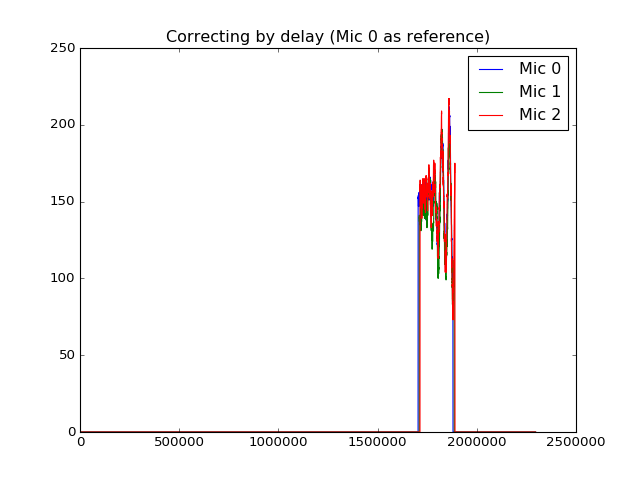

In [38]:
plt.figure()
plt.plot(np.arange(len(sigs_win[0])), sigs_win[0], label='Mic 0')
plt.plot(np.arange(len(sigs_win[1])), np.roll(sigs_win[1], -int(delays_raw[0][1])), label='Mic 1')
plt.plot(np.arange(len(sigs_win[2])), np.roll(sigs_win[2], -int(delays_raw[0][2])), label='Mic 2')
plt.legend(loc='best')
plt.title('Correcting by delay (Mic 0 as reference)')
plt.show()

<IPython.core.display.Javascript object>


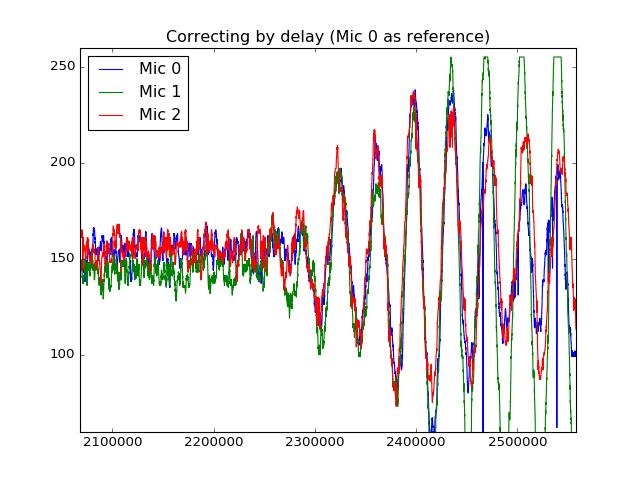

In [39]:
plt.figure()
plt.plot(np.arange(len(mic_0_med)), mic_0_med, label='Mic 0')
plt.plot(np.arange(len(mic_1_med)), np.roll(mic_1_med, -int(delays_raw[0][1])), label='Mic 1')
plt.plot(np.arange(len(mic_2_med)), np.roll(mic_2_med, -int(delays_raw[0][2])), label='Mic 2')
plt.legend(loc='best')
plt.title('Correcting by delay (Mic 0 as reference)')
plt.show()